<a href="https://colab.research.google.com/github/ChoiDae1/2022_Korea_Compuer_Vision_Society_Programming/blob/main/Deep_Learning_%EA%B8%B0%EC%B4%88_%EB%B0%8F_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KCVS 2022 Spring 실습 1 - Image classification

첫번째 실습은 간단한 deep network를 이용한 image classification입니다. 특히, CIFAR10 dataset을 가지고 image classification을 코드로 구현하여, 10-class classification이 동작하는 것을 확인하고 image encoding과 classification의 end-to-end model 학습을 해 보는 것을 목표로 합니다.

우선 실행의 결과를 이 browser에서 보기 위해 아래 명령어를 실행해 줍니다.



In [ ]:
%matplotlib inline

## Dataset

학습을 위해서는 3가지가 꼭 필요합니다 (1) dataset, (2) model, (3) computing resource.  이 중 첫번째인 dataset은 학습된 모델의 성능에 큰 영향을 주는 중요한 요소라 할 수 있습니다. 본 실습에서는 학습된 모델의 일반화 성능을 고려하기 보다는 학습 과정을 살펴보기 위한 목적이 크기 때문에, 적당한 크기의 데이터 셋인 CIFAR-10 데이터 셋을 이용하겠습니다. 

CIFAR-10 데이터 셋에는 다음과 같은 분류들이 있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)', '사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'. 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.

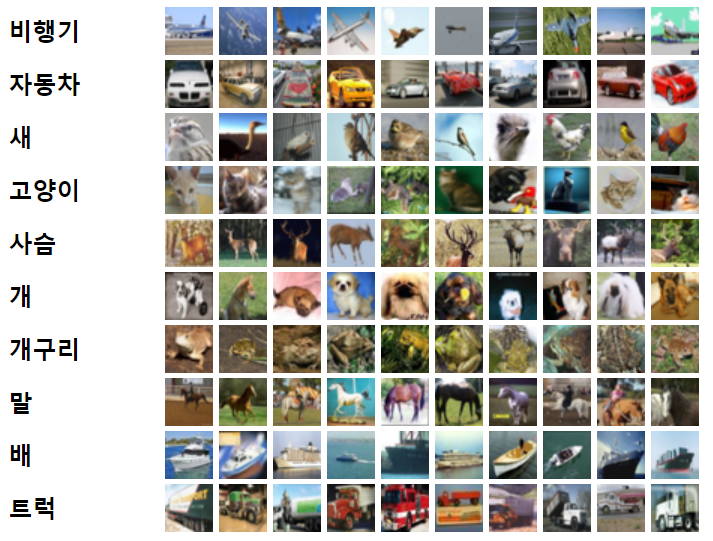

## 준비 - Loading dataset

이미지를 처리하기 위해서 보통 Pillow, OpenCV 등을 사용하는 것이 일반적입니다. 그런데 PyTorch에서는 `torchvision` 이라는 package를 제공합니다. 이 패키지에는 ImageNet, CIFAR10, MNIST 등의 데이터 셋의 data loader를 제공합니다. 

(이 밖의 데이터 셋을 사용하기 위해서는 직접 loader를 구현해야 합니다. $\leftarrow$ 강력 추천합니다 😀)

In [ ]:
# Import Library
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

## Overview

다음과 같은 단계로 진행할 예정입니다.

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

## CIFAR10을 불러오고 normalize 하기

``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


데이터가 잘 load되었는지 이미지 몇장을 시각화하여 확인합니다.

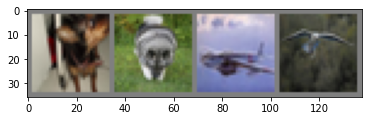

dog   dog   plane bird 


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Implementing a CNN model

아래와 같이 CNN 모델을 정의하기 위해 구현합니다.

### 네트워크 구조 정의

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 손실 함수와 Optimizer 정의하기

교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 신경망 학습하기 

데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면 됩니다. 한번 데이터를 반복하는 것을 epoch이라고 합니다.

In [ ]:
max_epoch = 2  # 데이터셋을 2차례 반복하여 학습합니다.
for epoch in range(max_epoch):   

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.200
[1,  4000] loss: 1.840
[1,  6000] loss: 1.703
[1,  8000] loss: 1.584
[1, 10000] loss: 1.521
[1, 12000] loss: 1.455
[2,  2000] loss: 1.415
[2,  4000] loss: 1.378
[2,  6000] loss: 1.345
[2,  8000] loss: 1.323
[2, 10000] loss: 1.326
[2, 12000] loss: 1.276
Finished Training


학습한 모델은 잘 저장해 둡니다. (안 그러면 또 학습해야 합니다.)

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Inference

학습된 모델로 새로운 데이터 (보통 test-set에 있는 데이터를 사용하기 때문에, test data라고 합니다)를 통해 label을 '추론'해 봅니다. 신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다. 만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.

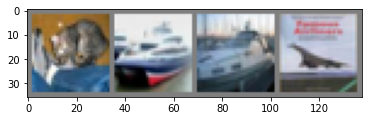

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:

In [ ]:
output = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   ship  car   cat  


그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.

In [ ]:
correct = 0
total = 0

with torch.no_grad(): # 학습 중이 아니므로, gradient를 계산할 필요가 없습니다
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 forward-pass해서 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


무작위로 찍었을 때의 정확도인 10% 보다는 나아보입니다. 신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 class들을 더 잘 분류하고, 어떤 class들을 더 못했는지 알아보겠습니다:

In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad(): # 역시 gradient는 필요하지 않습니다
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 각 class별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.9 %
Accuracy for class: car   is 74.7 %
Accuracy for class: bird  is 25.8 %
Accuracy for class: cat   is 54.7 %
Accuracy for class: deer  is 41.7 %
Accuracy for class: dog   is 24.1 %
Accuracy for class: frog  is 70.9 %
Accuracy for class: horse is 72.3 %
Accuracy for class: ship  is 64.5 %
Accuracy for class: truck is 64.9 %


수고 하셨습니다!